In [3]:
import os
import dotenv

dotenv.load_dotenv()
os.environ["TOKENIZERS_PARALLELISM"] = 'true'

from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

/var/folders/bh/ws9sfd0573s8xjtb61qbklnh0000gn/T/ipykernel_27206/2518515666.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [4]:
from langchain_ollama import ChatOllama
local_llm = 'llama3.2:3b'
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format='json')

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model='nomic-embed-text-v1.5', inference_mode='local'),
)

retriever = vectorstore.as_retriever(k=3)

USER_AGENT environment variable not set, consider setting it to identify your requests.
Embedding texts: 100%|██████████| 28/28 [00:03<00:00,  7.85inputs/s]


In [6]:
import json
from langchain_core.messages import HumanMessage, SystemMessage

router_instructions = """You are an expert at routing a user question to a vectorstore or web search

The vector store contains documents about agents and prompt engineering

Use the vectorstore for these topics. For all else use web search

Return a JSON with a single key, datasource, that is 'websearch' or 'vectorstore' depending on the question."""

question = [HumanMessage("What are the types of agent memory")]
test_vector_store = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + question)
json.loads(test_vector_store.content)

{'datasource': 'vectorstore'}

In [7]:
doc_grader_instructions = """You are a grader assessing the relevance of a retrieved document to a user question

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant"""

doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}.

Think carefully and objectively assess whether the document contains at least some information relevant to the question.

Return a JSON with a single key, binary_score, that is 'yes' or 'no' to indicate whether the document contains at least some information relevant to the quesiton"""

question = "What is chain of thought prompting"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(document=doc_txt, question=question)
result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
json.loads(result.content)

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 13.49inputs/s]


{'binary_score': 'yes'}

In [8]:
rag_prompt = """You are an assistant for question answering tasks

here is the context to use to answer the users question: \n\n {context}

think carefully about the above context.

Now, review the user question: \n\n {question}

Provide an answer to this question using only the above context

Use three sentences maximum and keep the answers concise

Answer:"""

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation.content)

Embedding texts: 100%|██████████| 1/1 [00:00<00:00, 47.90inputs/s]


Chain-of-Thought (CoT) prompting generates a sequence of short sentences to describe reasoning logics step by step, known as reasoning chains or rationales, to eventually lead to the final answer. This technique is particularly beneficial for complicated reasoning tasks, where large models with more than 50B parameters can benefit from it. CoT prompts can be few-shot or zero-shot, and they have been shown to improve performance on various NLP tasks, including question-answering and natural language inference.


In [9]:
hallucination_grader_instructions = """You are a teacher grading a quiz

You will be given FACTS and a STUDENT ANSWER

Here is the criteria to follow

(1) Ensure that the STUDENT ANSWER is grounded in the FACTS

(2) Ensure that the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS

Score:

A score of yes means that the student's answer meets all of the criteria. This is the best score

A score of no mean that the student's answer fails to meet all of the criteria. This is the lowest score you can give

Explain your reasoning in a step by step manner to ensure that your reasoning and conclusion are correct

Avoid simply stating the correct answer

You are not grading how accurate the student answer is, only if it meets the above criteria, which is to ensure that the STUDENT ANSWER comes only from the FACTS

Do not grade 'no' if the STUDENT ANSWER is incorrect, only grade no if the answer does not come from the FACTS.

Grade 'yes' if the STUDENT ANSWER is fully grounded in the FACTS, regardless of factual accuracy"""

hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}

return a JSON with two keys, binary_score is 'yes' or 'no' score to grade whether the STUDENT ANSWER is grounded in FACTS, and a key, explanation, which contains an explanation of the score"""

hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=docs_txt, generation=generation)
result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': 'The student answer is grounded in the facts. The definition of Chain-of-Thought (CoT) prompting from the provided text states that it generates a sequence of short sentences to describe reasoning logics step by step, known as reasoning chains or rationales, to eventually lead to the final answer. This technique is particularly beneficial for complicated reasoning tasks, where large models with more than 50B parameters can benefit from it. The student answer accurately describes this concept and its benefits, making it a correct representation of the facts.'}

In [10]:
final_answer_grader_instructions = """You are a teacher grading a quiz

You will be given a QUESTION and a STUDENT ANSWER

Here is the criteria to follow

(1) Ensure that the STUDENT ANSWER helps to answer the QUESTION

Score:

A score of yes means that the student's answer meets all of the criteria. This is the best score

A score of no mean that the student's answer fails to meet all of the criteria. This is the lowest score you can give

Explain your reasoning in a step by step manner to ensure that your reasoning and conclusion are correct

Avoid simply stating the correct answer
"""

final_answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}

return a JSON with two keys, binary_score is 'yes' or 'no' score to grade whether the STUDENT ANSWER helps to answer the QUESTION and meets the criteria, and a key, explanation, which contains an explanation of the score"""

question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

final_answer_grader_prompt_formatted = final_answer_grader_prompt.format(question=question, generation=answer)
result = llm_json_mode.invoke([SystemMessage(content=final_answer_grader_instructions)] + [HumanMessage(content=final_answer_grader_prompt_formatted)])
json.loads(result.content)


{'binary_score': 'yes',
 'explanation': ["The student's answer mentions two specific vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are indeed part of the Llama 3.2 release.",
  'The student also correctly states that these models are available on Azure AI Model Catalog via managed compute and that they replace the older text-only Llama 3.1 models.',
  "Additionally, the student provides context about Meta's first foray into multimodal AI and compares these models to other visual reasoning models like Claude 3 Haiku and GPT-4o mini from Anthropic and OpenAI respectively.",
  'However, it is worth noting that the student does not explicitly state that these are the only vision models released as part of Llama 3.2, which could be considered a minor omission.',
  "Overall, the student's answer provides sufficient information to address the question and meets most of the criteria."]}

In [11]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated

class GraphState(TypedDict):
    question: str # user quesiton
    generation: str # LLM answer
    web_search: str # binary decision to run web search
    max_retries: int # retry depth max for answer generation
    answers: int # number of answers generated
    loop_step: Annotated[int, operator.add]
    documents: List[str]

In [12]:
from langchain.schema import Document
from langgraph.graph import END

def retrieve(state):
    print("--RETRIEVING--")
    question = state["question"]
    docs = retriever.invoke(question)
    
    return {"documents": docs}

def generate(state):
    print("--GENERATING--")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    rag_prompt_formatted = rag_prompt.format(context=documents, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step+1}

def grade_documents(state):
    print("--GRADING DOCUMENTS--")
    documents = state["documents"]
    question = state["question"]
    
    filtered_docs = []
    web_search_flag="no"
    for document in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=document, question=question)
        result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
        grade = json.loads(result.content)["binary_score"]
        
        if grade.lower() == "yes":
            print("--DOCUMENT FOUND RELEVANT--")
            filtered_docs.append(document)
            
        else:
            print("--DOCUMENT FOUND IRRELEVANT--")
            web_search_flag = 'yes'
    
    return {"documents": filtered_docs, "web_search": web_search_flag}
    
def web_search(state):
    print("--WEB SEARCH--")
    
    question = state["question"]
    documents = state["documents"]    
    
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join(document["content"] for document in docs)
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    
    return {"documents": documents}

def route_question(state):
    print("--ROUTING--")
    question = [HumanMessage(state["question"])]
    test_vector_store = llm_json_mode.invoke([SystemMessage(content=router_instructions)] + question)
    source = json.loads(test_vector_store.content)['datasource']
    
    print(f"--ROUTING TO {source}")
    return source

def decide_to_generate(state):
    print("--DECIDING TO GENERATE--")
    
    question = state["question"]
    documents = state["documents"]
    web_search_flag = state["web_search"]
    
    if web_search_flag == 'yes':
        print("--NOT ALL DOCUMENTS RELEVANT: ROUTING TO WEBSEARCH--")
        return "websearch"
    else:
        print("--ALL DOCUMENTS RELEVANT: GENERATING CONTENT")
        return "generate"
    
def grade_generation_and_check_hallucinations(state):
    documents = state["documents"]
    question = state["question"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3)
    loop_step = state["loop_step"]
    
    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=documents, generation=generation)
    result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    grade = json.loads(result.content)['binary_score']
    
    if grade.lower() == 'yes':
        print("--GROUNDED IN DOCUMENTS--")
        
        final_answer_grader_prompt_formatted = final_answer_grader_prompt.format(question=question, generation=generation)
        result = llm_json_mode.invoke([SystemMessage(content=final_answer_grader_instructions)] + [HumanMessage(content=final_answer_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        
        if grade.lower() == "yes":
            print("--USEFUL--")
            return "useful"
        elif loop_step <= max_retries:
            print("--NOT USEFUL")
            return "not useful"
        else:
            print("--MAX RETRIES REACHED--")
            return "max retries"
        
    elif loop_step <= max_retries:
        print("--HALLUCINATION FOUND: RETRYING")
        return "not supported"
    else:
        print("--MAX RETRIES REACHED")
        return "max retries"

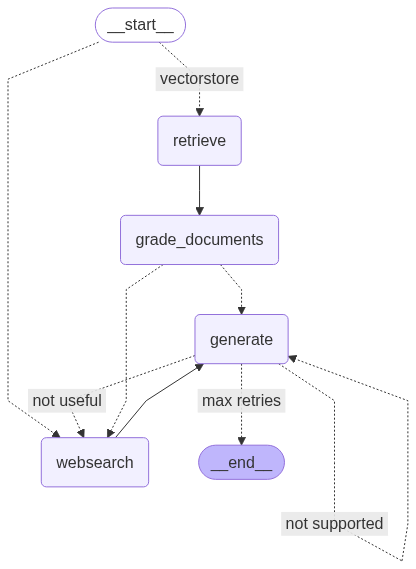

In [13]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

workflow.add_node("websearch", web_search)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)

workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve"
    }
)

workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate"
    }
)

workflow.add_conditional_edges(
    "generate",
    grade_generation_and_check_hallucinations,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END
    }
)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
# inputs = {"question": "what is an agent", "max_retries": 3}
# output = graph.invoke(input=inputs)
# print(output['generation'].content)